In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from imblearn.over_sampling import SMOTE
import nlpaug.augmenter.word as naw

In [6]:
# Ensure required downloads for NLTK
nltk.download('wordnet', quiet=True)

True

In [7]:
# Load dataset
df = pd.read_csv("chando_ dataset.csv")

In [8]:
# Data Cleaning
def clean_dataset(df):
    df.dropna(subset=['headline', 'label'], inplace=True)  # Remove NaN values
    df['label'] = df['label'].replace(-1, 1)  # Convert -1 labels to 1
    df['tidy_tweet'] = df['headline'].str.replace(r"[^a-zA-Z#]", " ", regex=True)  # Remove special characters
    df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))  # Remove short words

    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()]))

    return df

df = clean_dataset(df)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['tidy_tweet'], df['label'], test_size=0.2, random_state=42)

In [10]:
# Vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=100000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
# Handle class imbalance using SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

In [12]:
# Save the vectorizer
pickle.dump(vectorizer, open("tfidf_vectorizer.pkl", "wb"))

In [13]:
# Define models to train
models = {
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "SGDClassifier": SGDClassifier()
}

# Train models and save them
results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    pickle.dump(model, open(f"{name}.pkl", "wb"))
    
    y_pred = model.predict(X_test_vec)
    
    results.append({
        "Algorithm": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


            Algorithm  Accuracy  F1 Score  Precision    Recall
0           LinearSVC  0.924021  0.868542   0.798838  0.951572
1  LogisticRegression  0.957117  0.918364   0.922296  0.914465
2       MultinomialNB  0.899303  0.832135   0.742596  0.946226
3        DecisionTree  0.906603  0.843915   0.754586  0.957233
4            AdaBoost  0.895405  0.759672   0.964199  0.626730
5   BaggingClassifier  0.904280  0.841788   0.746232  0.965409
6       SGDClassifier  0.938454  0.876744   0.929225  0.829874


C:\Users\lenovo\AppData\Local\Temp\ipykernel_26336\3853516978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Algorithm", y="F1 Score", data=results_df, palette="viridis")


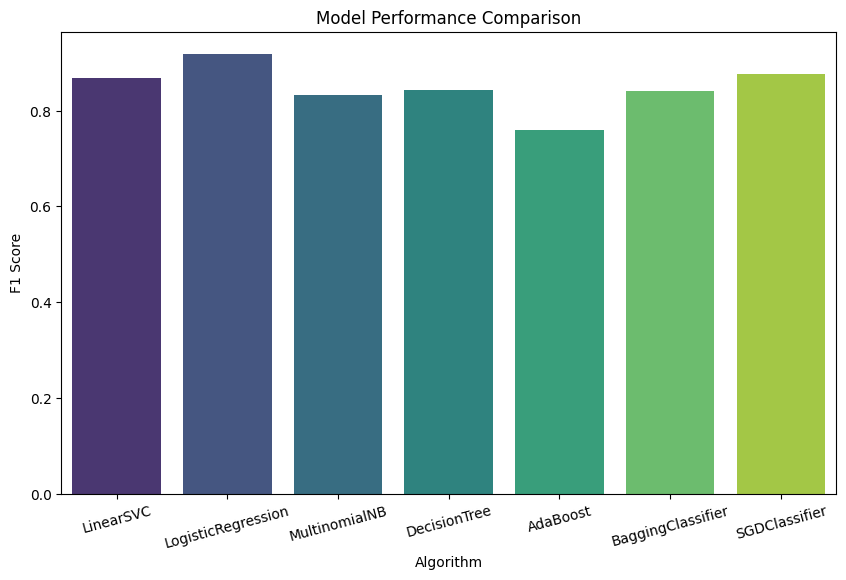

In [14]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="Algorithm", y="F1 Score", data=results_df, palette="viridis")
plt.xticks(rotation=15)
plt.title("Model Performance Comparison")
plt.show()

In [15]:
# Load and Test Model
model_name = "LinearSVC.pkl"
loaded_model = pickle.load(open(model_name, "rb"))

# Sample Prediction
sample_text = ["You are so beautiful"]
sample_vectorized = vectorizer.transform(sample_text)
prediction = loaded_model.predict(sample_vectorized)

print("Prediction:", "bullying" if prediction == 1 else "non-bullying")




Prediction: non-bullying


In [16]:
# Hyperparameter tuning function
def tune_model(clf, param_grid):
    scorer = make_scorer(f1_score, average='weighted')
    grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vec)
    
    print("Best Params:", grid_search.best_params_)
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    
    return best_model

# Example tuning on LogisticRegression
logreg_params = {"C": [0.1, 1, 10], "max_iter": [100, 200]}
best_logreg = tune_model(LogisticRegression(), logreg_params)

Best Params: {'C': 1, 'max_iter': 100}
F1 Score: 0.9570579367589244
Accuracy: 0.9571167883211679
Precision: 0.9570111885022728
Recall: 0.9571167883211679
